# **Text-to-3D**
A basic implementation of creating 3D models from text utilizes OpenAI for image sampling, Neural Radiance Fields (NeRF) for 3D model generation, Marching Cubes for mesh rendering, and a texture generation process to enhance realism. By combining these techniques, we aim to transform textual descriptions into detailed and visually appealing 3D models. The user interface facilitates interaction, allowing users to input text, visualize models, and provide feedback for iterative refinement, creating a robust system for translating textual concepts into immersive 3D representations.

In [21]:
!pip install --upgrade openai

In [22]:
import requests
from io import BytesIO
from PIL import Image
from openai import OpenAI
import numpy as np
import matplotlib.pyplot as plt
import os, sys

In [23]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    %tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [24]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
from tqdm import tqdm_notebook as tqdm

In [25]:
if not os.path.exists('tiny_nerf_data.npz'):
    !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

# Add Prompt

In [26]:
prompt = "A closed red book"

# Sampling Images
Add OpenAI Key

In [27]:
api_key = ""

In [28]:
def create_view_matrix(view_direction):
    translation_value = 10
    view_matrix = np.eye(4)
    if view_direction == 'top':
        view_matrix[1, 3] = translation_value
    elif view_direction == 'left':
        view_matrix = np.array([[0, 0, 1, 0],
                                [0, 1, 0, 0],
                                [-1, 0, 0, translation_value],
                                [0, 0, 0, 1]])
    elif view_direction == 'right':
        view_matrix = np.array([[0, 0, -1, 0],
                                [0, 1, 0, 0],
                                [1, 0, 0, translation_value],
                                [0, 0, 0, 1]])
    elif view_direction == 'front':
        view_matrix[2, 3] = translation_value
    elif view_direction == 'back':
        view_matrix = np.array([[-1, 0, 0, 0],
                                [0, 1, 0, 0],
                                [0, 0, -1, translation_value],
                                [0, 0, 0, 1]])
    else:
        raise ValueError("Invalid view_direction. Use 'top', 'left', 'right', 'front', or 'back'.")
    return view_matrix

In [29]:
client = OpenAI(api_key=api_key)

def generate_image(prompt):
  response = client.images.generate(
    model="dall-e-2",
    prompt=prompt,
    size="256x256",
    quality="standard",
    n=1,
  )
  image_url = response.data[0].url
  return image_url


def generate_image_set(prompt):
  texts = ["right", "front", "top", "back", "left"]
  images = []
  for i in range(len(texts)):
    updated_prompt = f"Generate image of 3d model of {prompt.lower()} with black background looking from {texts[i%len(texts)]}"
    image_url = generate_image(updated_prompt);
    response = requests.get(image_url)

    # Add Image
    img = BytesIO(response.content)
    img_array = np.array(Image.open(img))
    img_pil = Image.fromarray(img_array)
    resized_img = img_pil.resize((100, 100))
    img_array = np.array(resized_img)
    images.append(img_array)
    # poses.append(create_view_matrix(texts[i]))
    print(f"Generated image {i}")
  print("Done")
  return images

_images = np.array(generate_image_set(prompt))


Generated image 0
Generated image 1
Generated image 2
Generated image 3
Generated image 4
Done


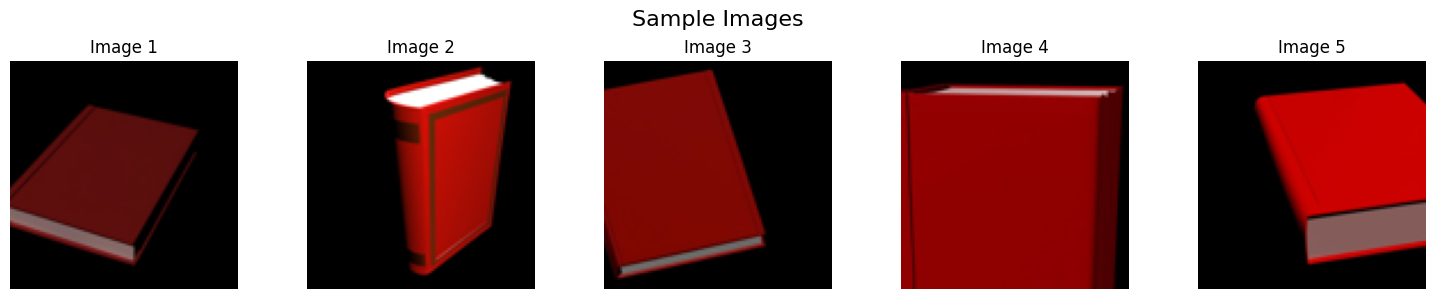

In [9]:
def show_images():
  fig, axes = plt.subplots(1, len(_images), figsize=(15, 3))
  fig.suptitle('Sample Images', fontsize=16)
  for i in range(len(_images)):
      axes[i].imshow(_images[i])
      axes[i].axis('off')
      axes[i].set_title(f'Image {i + 1}')
  plt.tight_layout()
  plt.show()

show_images()

(5, 100, 100, 3) (106, 4, 4) 138.88887889922103


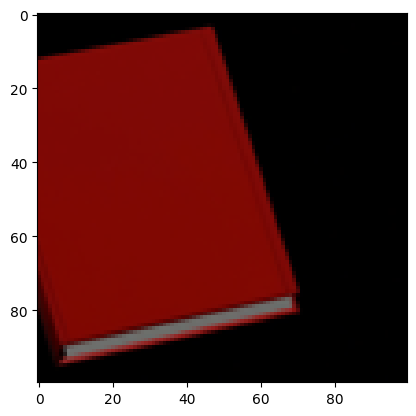

In [10]:
data = np.load('tiny_nerf_data.npz')
images = _images # data['images']
poses = data['poses']
focal = data['focal']
H, W = images.shape[1:3]
print(images.shape, poses.shape, focal)

testimg, testpose = images[2], poses[2]
images = images[:5,...,:3]
poses = poses[:5]

plt.imshow(testimg)
plt.show()

# Optimize NeRF

In [11]:
def posenc(x):
  rets = [x]
  for i in range(L_embed):
    for fn in [tf.sin, tf.cos]:
      rets.append(fn(2.**i * x))
  return tf.concat(rets, -1)

L_embed = 6
embed_fn = posenc
# L_embed = 0
# embed_fn = tf.identity

def init_model(D=8, W=256):
    relu = tf.keras.layers.ReLU()
    dense = lambda W=W, act=relu : tf.keras.layers.Dense(W, activation=act)

    inputs = tf.keras.Input(shape=(3 + 3*2*L_embed))
    outputs = inputs
    for i in range(D):
        outputs = dense()(outputs)
        if i%4==0 and i>0:
            outputs = tf.concat([outputs, inputs], -1)
    outputs = dense(4, act=None)(outputs)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


def get_rays(H, W, focal, c2w):
    i, j = tf.meshgrid(tf.range(W, dtype=tf.float32), tf.range(H, dtype=tf.float32), indexing='xy')
    dirs = tf.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -tf.ones_like(i)], -1)
    rays_d = tf.reduce_sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)
    rays_o = tf.broadcast_to(c2w[:3,-1], tf.shape(rays_d))
    return rays_o, rays_d



def render_rays(network_fn, rays_o, rays_d, near, far, N_samples, rand=False):

    def batchify(fn, chunk=1024*32):
        return lambda inputs : tf.concat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0)

    # Compute 3D query points
    z_vals = tf.linspace(near, far, N_samples)
    if rand:
      z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]

    # Run network
    pts_flat = tf.reshape(pts, [-1,3])
    pts_flat = embed_fn(pts_flat)
    raw = batchify(network_fn)(pts_flat)
    raw = tf.reshape(raw, list(pts.shape[:-1]) + [4])

    # Compute opacities and colors
    sigma_a = tf.nn.relu(raw[...,3])
    rgb = tf.math.sigmoid(raw[...,:3])

    # Do volume rendering
    dists = tf.concat([z_vals[..., 1:] - z_vals[..., :-1], tf.broadcast_to([1e10], z_vals[...,:1].shape)], -1)
    alpha = 1.-tf.exp(-sigma_a * dists)
    weights = alpha * tf.math.cumprod(1.-alpha + 1e-10, -1, exclusive=True)

    rgb_map = tf.reduce_sum(weights[...,None] * rgb, -2)
    depth_map = tf.reduce_sum(weights * z_vals, -1)
    acc_map = tf.reduce_sum(weights, -1)

    return rgb_map, depth_map, acc_map

Here we optimize the model. We plot a rendered holdout view and its PSNR every 50 iterations.

0 0.4491891860961914 secs per iter


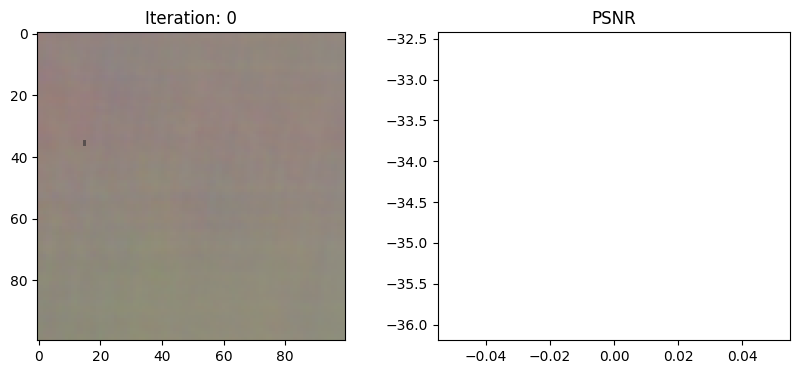

5 0.7247490406036377 secs per iter


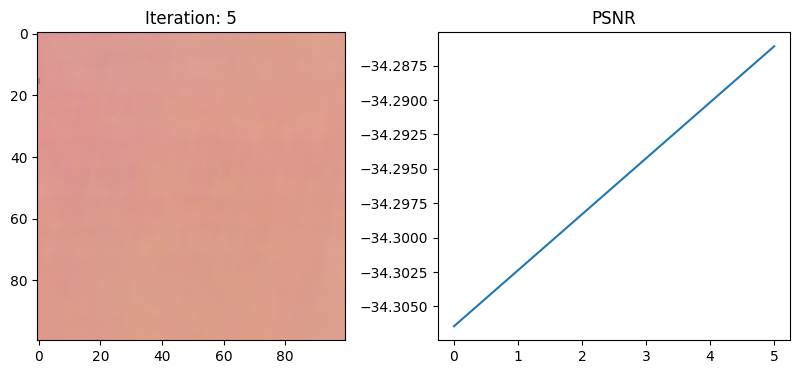

10 0.8143087387084961 secs per iter


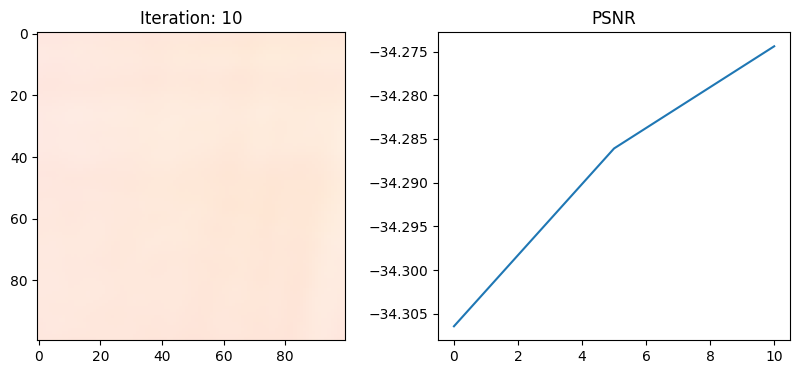

15 0.7868956565856934 secs per iter


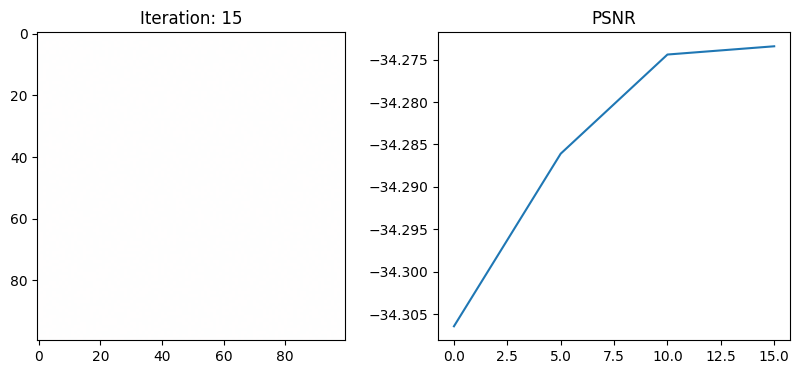

20 0.7877235889434815 secs per iter


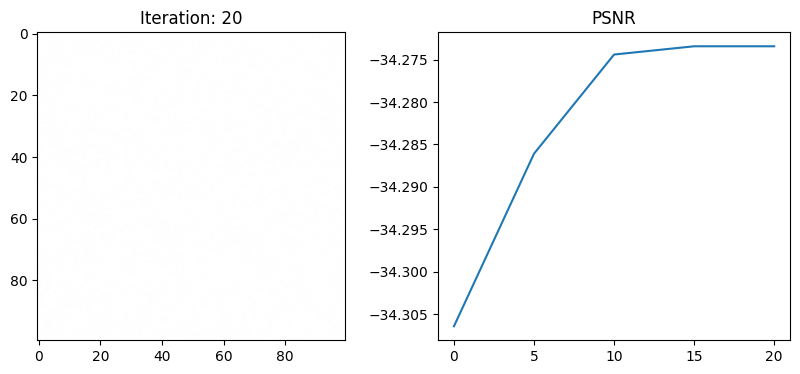

25 1.2454940795898437 secs per iter


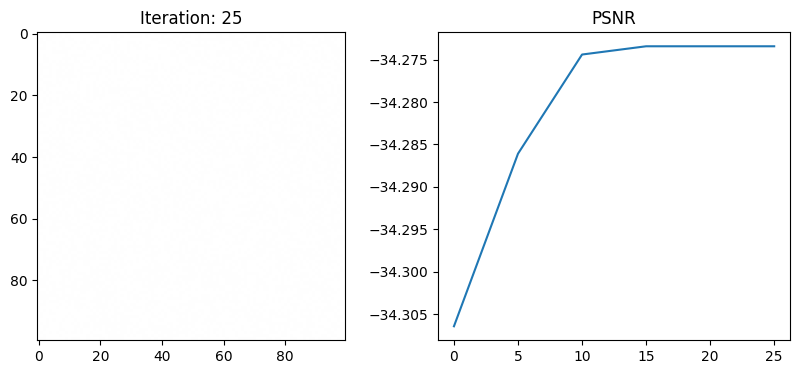

30 0.8595878124237061 secs per iter


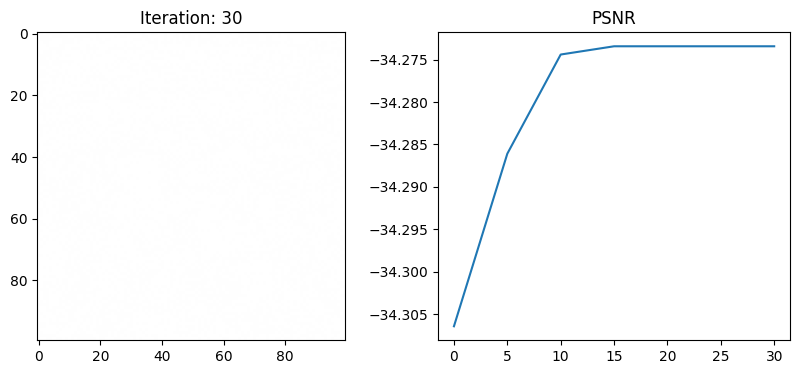

35 0.9203302383422851 secs per iter


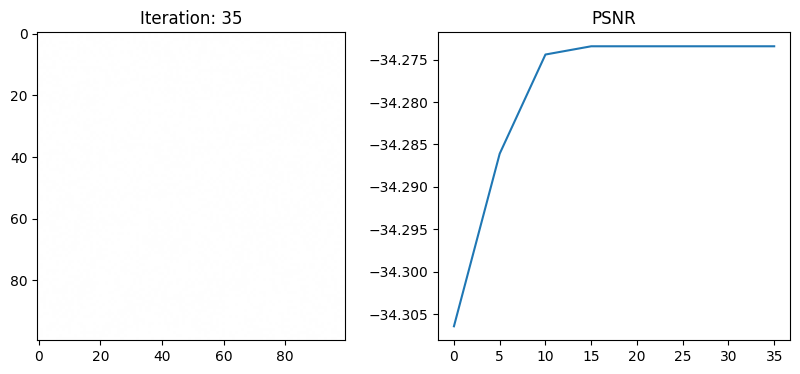

40 0.9263883590698242 secs per iter


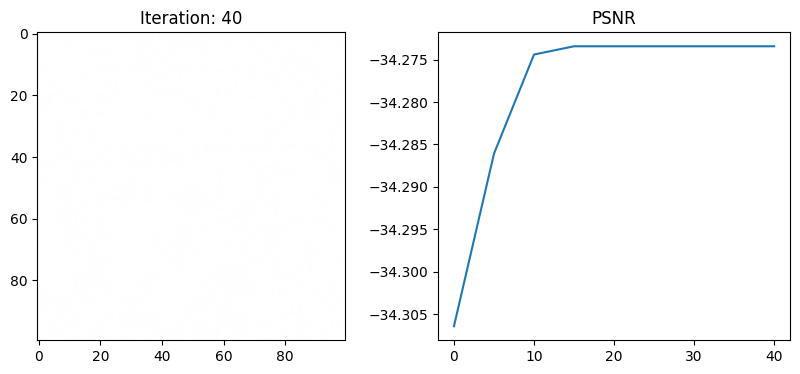

45 0.7883870124816894 secs per iter


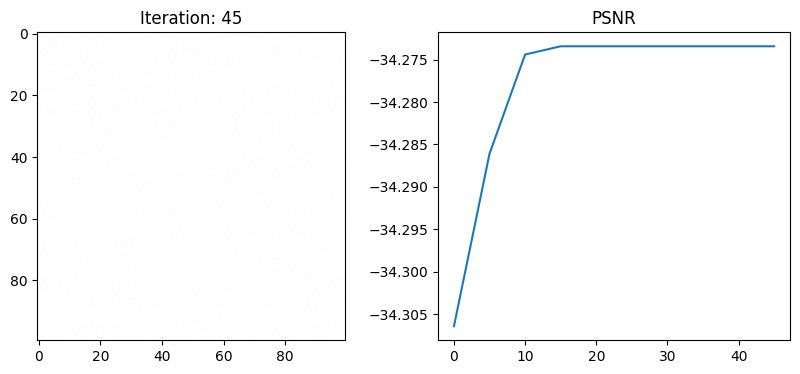

50 0.7804769515991211 secs per iter


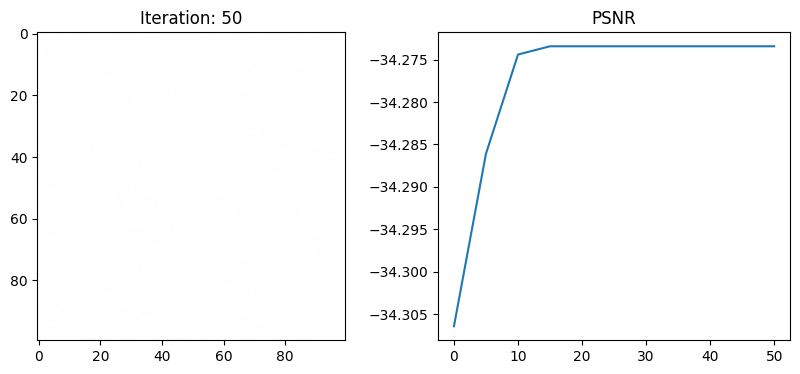

55 0.8756730556488037 secs per iter


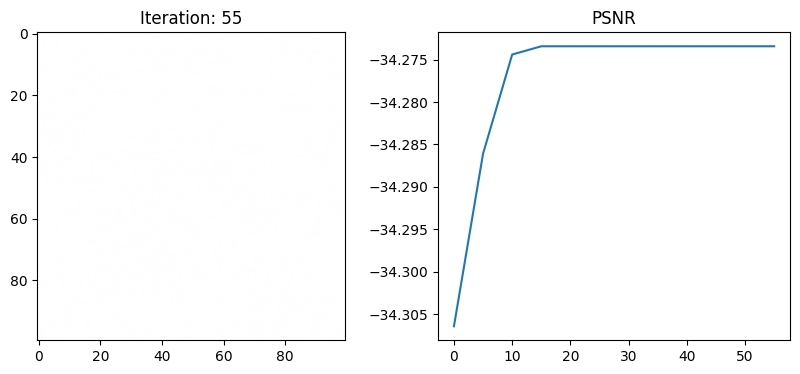

60 0.7825097560882568 secs per iter


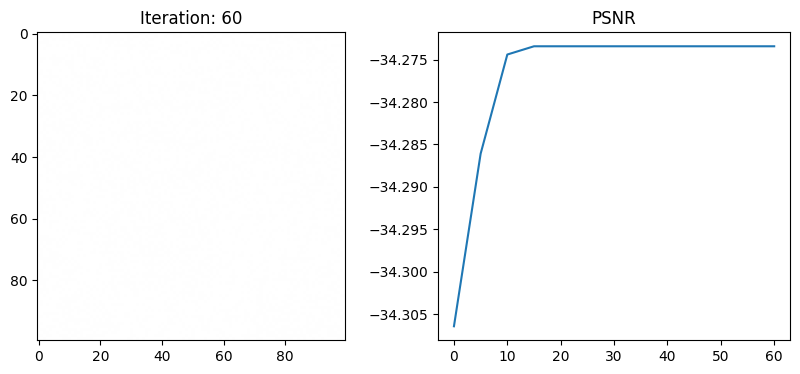

65 0.7820429325103759 secs per iter


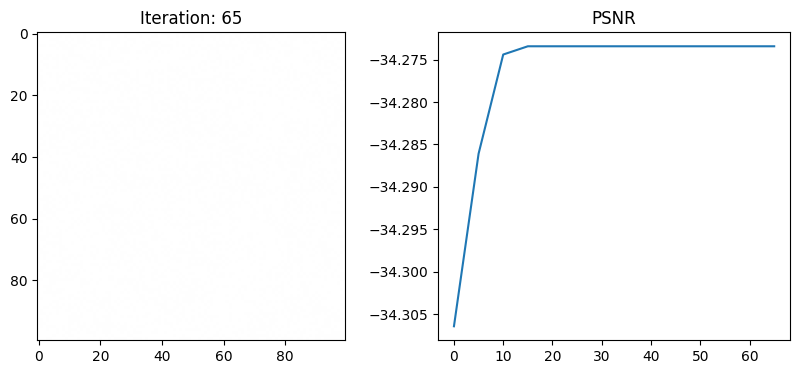

70 0.8325681686401367 secs per iter


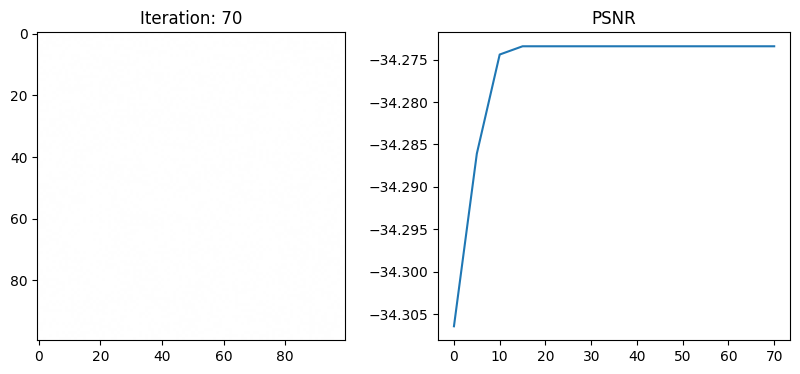

75 0.7902791023254394 secs per iter


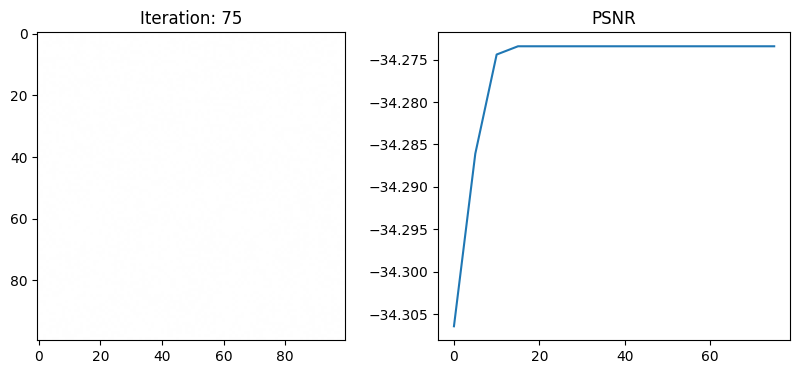

80 0.8067907810211181 secs per iter


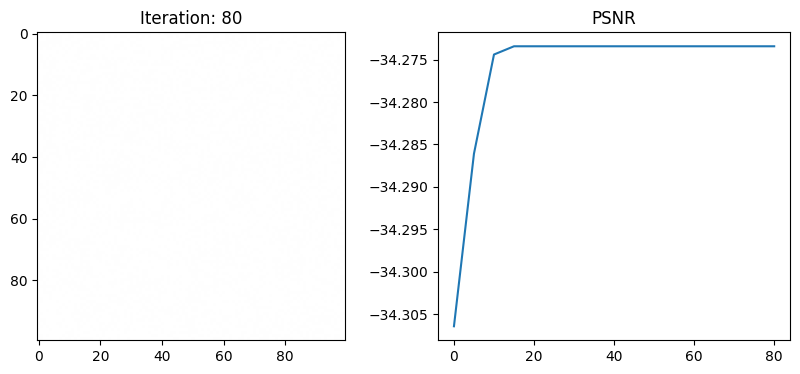

85 0.8236453533172607 secs per iter


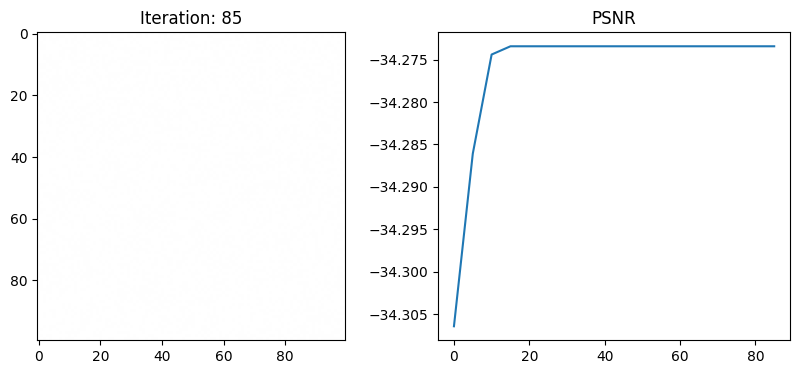

90 0.8008370876312256 secs per iter


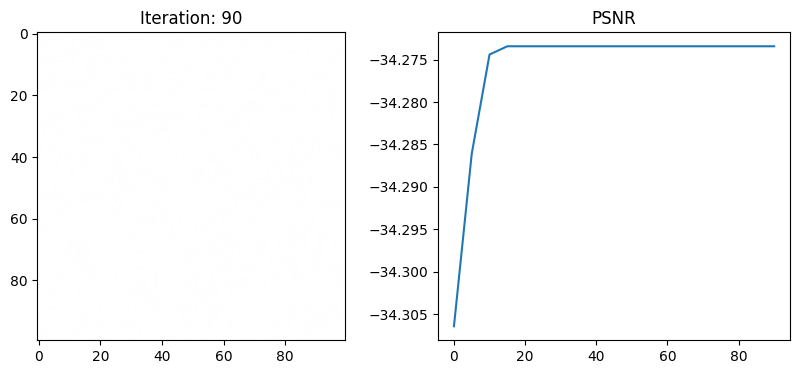

95 0.8022168636322021 secs per iter


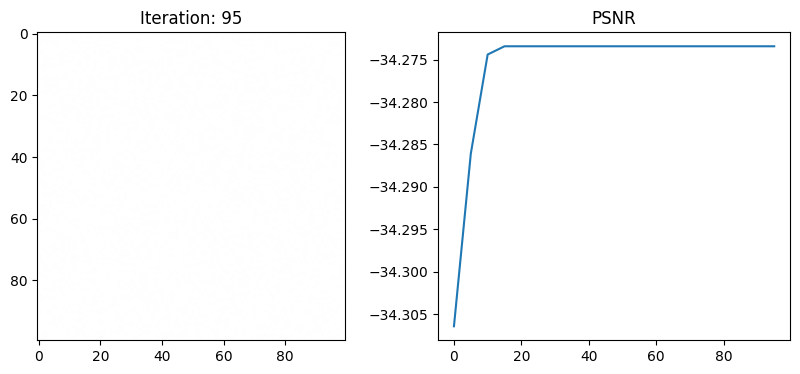

100 0.8047232151031494 secs per iter


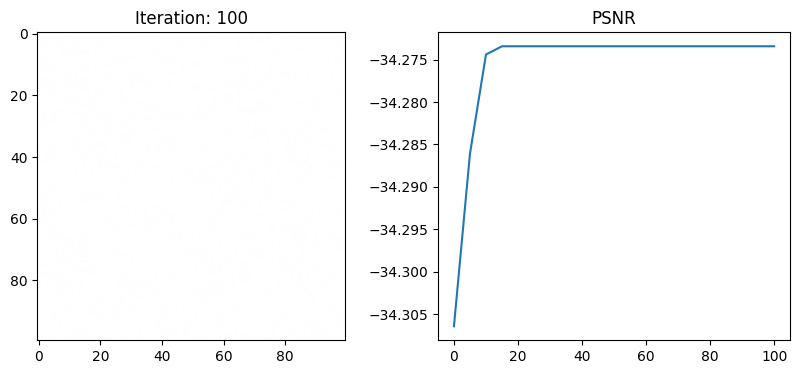

Done


In [14]:
model = init_model()
optimizer = tf.keras.optimizers.Adam(5e-4)

N_samples = 64
N_iters = 100
psnrs = []
iternums = []
i_plot = 5

import time
t = time.time()
for i in range(N_iters+1):

    img_i = np.random.randint(images.shape[0])
    target = images[img_i]
    pose = poses[img_i]
    rays_o, rays_d = get_rays(H, W, focal, pose)
    with tf.GradientTape() as tape:
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples, rand=True)
        loss = tf.reduce_mean(tf.square(rgb - target))
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    if i%i_plot==0:
        print(i, (time.time() - t) / i_plot, 'secs per iter')
        t = time.time()

        # Render the holdout view for logging
        rays_o, rays_d = get_rays(H, W, focal, testpose)
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
        loss = tf.reduce_mean(tf.square(rgb - testimg))
        psnr = -10. * tf.math.log(loss) / tf.math.log(10.)

        psnrs.append(psnr.numpy())
        iternums.append(i)

        plt.figure(figsize=(10,4))
        plt.subplot(121)
        plt.imshow(rgb)
        plt.title(f'Iteration: {i}')
        plt.subplot(122)
        plt.plot(iternums, psnrs)
        plt.title('PSNR')
        plt.show()

print('Done')

# Interactive Visualization

In [17]:
%matplotlib inline
from ipywidgets import interactive, widgets


trans_t = lambda t : tf.convert_to_tensor([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1],
], dtype=tf.float32)

rot_phi = lambda phi : tf.convert_to_tensor([
    [1,0,0,0],
    [0,tf.cos(phi),-tf.sin(phi),0],
    [0,tf.sin(phi), tf.cos(phi),0],
    [0,0,0,1],
], dtype=tf.float32)

rot_theta = lambda th : tf.convert_to_tensor([
    [tf.cos(th),0,-tf.sin(th),0],
    [0,1,0,0],
    [tf.sin(th),0, tf.cos(th),0],
    [0,0,0,1],
], dtype=tf.float32)


def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]) @ c2w
    return c2w


def f(**kwargs):
    c2w = pose_spherical(**kwargs)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])
    rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
    img = np.clip(rgb,0,1)

    plt.figure(2, figsize=(20,6))
    plt.imshow(img)
    plt.show()


sldr = lambda v, mi, ma: widgets.FloatSlider(
    value=v,
    min=mi,
    max=ma,
    step=.01,
)

names = [
    ['theta', [100., 0., 360]],
    ['phi', [-30., -90, 0]],
    ['radius', [4., 3., 5.]],
]

interactive_plot = interactive(f, **{s[0] : sldr(*s[1]) for s in names})
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=100.0, description='theta', max=360.0, step=0.01), FloatSlider(value=-…

# Render 360 Video

In [18]:
frames = []
for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):
    c2w = pose_spherical(th, -30., 4.)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])
    rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
    frames.append((255*np.clip(rgb,0,1)).astype(np.uint8))

import imageio
f = 'video.mp4'
imageio.mimwrite(f, frames, fps=30, quality=7)

<ipython-input-18-bc28ed268829>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):


  0%|          | 0/120 [00:00<?, ?it/s]

In [19]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

Implement Marching Cubes to convert to mesh

Generate Texture based on mesh